##### Using a genetic algorithm to search for relevant features in the compiled target dataframe

The sklearn.svm.NuSVR algorithm is a good performer with this data, and immediately returns a model with 95% R2 on the test set when fed all the features. The goal here is to find a minimal set of features that performs nearly as well, since not all algorithms are as tolerant of high dimensions, and maintaining feature sets is labor intensive. 

I find this preferable to Principle Component Analysis because PCA doesn't evaluate outlier target variables; it only shows vectors of movement within correlated inputs. This is useful but in a situation where mis-predicted outliers are dangerous, it may be better to find a subset of features that performs as well and just use those. 

Another reason to prefer this over PCA, if it works, is that it is much easier to continually collect data on a smaller number of features that matter than on a larger number of features that need to be fed into PCA.

## Uses https://pypi.org/project/sklearn-genetic/ 
Citation: Manuel Calzolari. (2021, April 3). manuel-calzolari/sklearn-genetic: sklearn-genetic 0.4.0 (Version 0.4.0). Zenodo. http://doi.org/10.5281/zenodo.4661178

Source code at https://github.com/manuel-calzolari/sklearn-genetic/blob/master/genetic_selection/gscv.py

NOTE:  DEAP, the library behind this library, mentions a different genetic option finding algorithm which is slightly newer: https://github.com/rodrigo-arenas/Sklearn-genetic-opt


## Additional setup reqired:
"conda install -c conda-forge sklearn-genetic"

# Runs in about 5 minutes on my laptop


In [1]:
# optional setup if running on Google Colab: 
# !pip install sklearn-genetic

In [2]:
# Import required libraries 

import pandas as pd 
import numpy as np 

### Load the predictors and target data to a pandas dataframe


In [3]:
# load from local CSV
target_df = pd.read_csv("dataframes/target_df.csv.gz", compression="infer", parse_dates = ["opday"])

# Load from github
#target_df = pd.read_csv("https://github.com/k5dru/CPSC_5383/blob/main/dataframes/target_df.csv.gz?raw=true", compression="gzip", parse_dates = ["opday"])


### View the source data

Always view the source data.  Pandas makes this trivial.

In [4]:
target_df.head()

,opday,sum_spp_load,is_Friday,is_Monday,is_Saturday,is_Sunday,is_Thursday,is_Tuesday,is_Wednesday,holiday_Christmas Day,...,HDD_TX_FT_WORTH_ALLIANCE_AP,HDD_TX_LUBBOCK,HDD_TX_MIDLAND_ODESSA,HDD_TX_SAN_ANGELO,HDD_TX_WACO_RGNL_AP,HDD_TX_WICHITA_FALLS_MUNI_AP,HDD_WY_CHEYENNE,HDD_WY_TORRINGTON_MUNI_AP,SUM_HDD,SUM_CDD
0,2015-10-03,566229.834662,0,0,1,0,0,0,0,0,...,1.05,5.28,0.00,0.0,0.0,3.30,18.24,16.98,73.32,4.38
1,2015-10-04,552166.723416,0,0,0,1,0,0,0,0,...,0.00,8.34,0.00,0.0,0.0,1.14,18.96,15.00,66.66,2.94
2,2015-10-05,596751.461994,0,1,0,0,0,0,0,0,...,0.00,7.44,1.14,0.0,0.0,1.14,12.30,7.08,61.62,4.02
3,2015-10-06,622735.355003,0,0,0,0,0,1,0,0,...,0.00,3.48,0.00,0.0,0.0,0.60,12.12,8.97,28.14,1.32
4,2015-10-07,645464.796588,0,0,0,0,0,0,1,0,...,0.00,0.00,0.00,0.0,0.0,0.00,7.44,0.51,18.90,5.58


In [5]:
target_df.describe()

,sum_spp_load,is_Friday,is_Monday,is_Saturday,is_Sunday,is_Thursday,is_Tuesday,is_Wednesday,holiday_Christmas Day,holiday_Christmas Eve,...,HDD_TX_FT_WORTH_ALLIANCE_AP,HDD_TX_LUBBOCK,HDD_TX_MIDLAND_ODESSA,HDD_TX_SAN_ANGELO,HDD_TX_WACO_RGNL_AP,HDD_TX_WICHITA_FALLS_MUNI_AP,HDD_WY_CHEYENNE,HDD_WY_TORRINGTON_MUNI_AP,SUM_HDD,SUM_CDD
count,1.535000e+03,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,...,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000
mean,7.178639e+05,0.142671,0.143974,0.142671,0.143322,0.141368,0.142671,0.143322,0.003909,0.003257,...,6.173375,8.910704,6.428717,5.824339,5.486463,7.879974,19.121863,18.240430,95.326866,33.324547
std,1.007130e+05,0.349851,0.351178,0.349851,0.350516,0.348514,0.349851,0.350516,0.062418,0.056999,...,9.136330,11.073380,9.305757,8.850519,8.568441,10.596462,15.683710,16.434591,99.562253,29.215506
min,5.400074e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.367939e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.480000,0.000000,1.320000,11.370000
50%,6.941424e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.760000,0.000000,0.000000,0.000000,0.960000,18.600000,16.890000,63.780000,23.640000
75%,7.862803e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.995000,16.620000,11.760000,10.500000,9.420000,14.190000,30.660000,29.850000,167.370000,46.920000
max,1.016596e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,44.970000,52.980000,46.860000,45.420000,44.520000,48.660000,69.540000,76.380000,445.200000,133.200000


In [6]:
target_df.columns


Index(['opday', 'sum_spp_load', 'is_Friday', 'is_Monday', 'is_Saturday',
       'is_Sunday', 'is_Thursday', 'is_Tuesday', 'is_Wednesday',
       'holiday_Christmas Day',
       ...
       'HDD_TX_FT_WORTH_ALLIANCE_AP', 'HDD_TX_LUBBOCK',
       'HDD_TX_MIDLAND_ODESSA', 'HDD_TX_SAN_ANGELO', 'HDD_TX_WACO_RGNL_AP',
       'HDD_TX_WICHITA_FALLS_MUNI_AP', 'HDD_WY_CHEYENNE',
       'HDD_WY_TORRINGTON_MUNI_AP', 'SUM_HDD', 'SUM_CDD'],
      dtype='object', length=485)

## Selection of the predictor measures

and convert the predictors and target to a numpy matrix and vector respectively



In [7]:
# One of the goals of dimension reduction is to reduce the amount of work it takes 
# to gather the data. 
# I am very interested in which airports' average temperatures are most effective 
# at predicting demand in the SPP; therefore I only use TAVG and left out TMIN, TMAX, HDD, and CDD. 

predictors_df = target_df[[
    'is_Friday', 'is_Monday', 'is_Saturday', 'is_Sunday', 'is_Thursday',
    'is_Tuesday', 'is_Wednesday', 'holiday_Christmas Day',
    'holiday_Christmas Eve', 'holiday_Day After Thanksgiving',
    'holiday_Independence Day', 'holiday_Labor Day', 'holiday_Memorial Day',
    "holiday_New Year's Day", 'holiday_Thanksgiving', 
    'is_holiday',
    'TAVG_AR_FAYETTEVILLE_DRAKE_FLD', 'TAVG_AR_FT_SMITH_RGNL_AP',
    'TAVG_AR_HARRISON_BOONE_CO_AP', 'TAVG_AR_HOT_SPRINGS_ASOS',
    'TAVG_AR_LITTLE_ROCK', 'TAVG_AR_LITTLE_ROCK_AP_ADAMS_FLD',
    'TAVG_AR_MOUNTAIN_HOME_BAXTER_AP', 'TAVG_AR_MOUNT_IDA_ASOS',
    'TAVG_AR_TEXARKANA_WEBB_FLD', 'TAVG_CO_ALAMOSA_SAN_LUIS_AP',
    'TAVG_CO_BURLINGTON_CARSON_AP', 'TAVG_CO_COLORADO_SPRINGS_MUNI_AP',
    'TAVG_CO_DENVER_CENTENNIAL_AP', 'TAVG_CO_DENVER_INTL_AP',
    'TAVG_CO_PUEBLO_MEM_AP', 'TAVG_IA_AMES_MUNI_AP',
    'TAVG_IA_DES_MOINES_INTL_AP', 'TAVG_IA_ESTHERVILLE_MUNI_AP',
    'TAVG_IA_MARSHALLTOWN_MUNI_AP', 'TAVG_IA_MASON_CITY_MUNI_AP',
    'TAVG_IA_SIOUX_CITY_GATEWAY_AP', 'TAVG_IA_WATERLOO_MUNI_AP',
    'TAVG_KS_ANTHONY', 'TAVG_KS_CONCORDIA_MUNI_AP', 'TAVG_KS_DODGE_CITY',
    'TAVG_KS_GOODLAND', 'TAVG_KS_HILL_CITY_MUNI_AP', 'TAVG_KS_TOPEKA_MUNI_AP',
    'TAVG_KS_WICHITA', 'TAVG_LA_SHREVEPORT', 'TAVG_MN_DULUTH',
    'TAVG_MN_INTL_FALLS_INTL_AP', 'TAVG_MN_MINNEAPOLIS/ST_PAUL_AP',
    'TAVG_MN_MPLS_CRYSTAL_AP', 'TAVG_MN_MPLS_FLYING_CLOUD_AP',
    'TAVG_MN_ROCHESTER_INTL_AP', 'TAVG_MN_ST_CLOUD_RGNL_AP',
    'TAVG_MN_ST_PAUL_DOWNTOWN_AP', 'TAVG_MO_KANSAS_CITY_INTL_AP',
    'TAVG_MO_SPRINGFIELD', 'TAVG_MT_BAKER_MUNI_AP',
    'TAVG_MT_MILES_CITY_F_WILEY_FLD', 'TAVG_ND_BISMARCK',
    'TAVG_ND_FARGO_HECTOR_INTL_AP', 'TAVG_ND_GARRISON',
    'TAVG_ND_GRAND_FORKS_INTL_AP', 'TAVG_ND_HETTINGER_MUNI_AP',
    'TAVG_ND_JAMESTOWN_MUNI_AP', 'TAVG_ND_MINOT_INTL_AP',
    'TAVG_ND_THEODORE_ROOSEVELT_AP', 'TAVG_NE_BROKEN_BOW_MUNI_AP',
    'TAVG_NE_CHADRON_MUNI_AP', 'TAVG_NE_FALLS_CITY_BRENNER_FLD',
    'TAVG_NE_GRAND_ISLAND_AP', 'TAVG_NE_HASTINGS_MUNI_AP',
    'TAVG_NE_HAYES_CENTER_1NW', 'TAVG_NE_IMPERIAL_MUNI_AP',
    'TAVG_NE_LINCOLN_MUNI_AP', 'TAVG_NE_NORFOLK_KARL_STEFAN_AP',
    'TAVG_NE_NORTH_PLATTE_RGNL_AP', 'TAVG_NE_OMAHA_EPPLEY_AIRFIELD',
    'TAVG_NE_SCOTTSBLUFF_HEILIG_AP', 'TAVG_NE_VALENTINE_MILLER_FLD',
    'TAVG_NM_CLAYTON_MUNI_AIR_PK', 'TAVG_NM_LAS_VEGAS_MUNI_AP',
    'TAVG_NM_ROSWELL_IND_AIR_PK', 'TAVG_OK_BARTLESVILLE_F_P_FLD',
    'TAVG_OK_LAWTON_MUNI_AP', 'TAVG_OK_OKLAHOMA_CITY_WILL_ROGERS_AP',
    'TAVG_OK_TULSA_INTL_AP', 'TAVG_SD_ABERDEEN', 'TAVG_SD_HURON_RGNL_AP',
    'TAVG_SD_MITCHELL_MUNI_AP', 'TAVG_SD_MOBRIDGE_MUNI_AP',
    'TAVG_SD_RAPID_CITY_RGNL_AP', 'TAVG_SD_SIOUX_FALLS',
    'TAVG_SD_SISSETON_MUNI_AP', 'TAVG_SD_WATERTOWN_RGNL_AP',
    'TAVG_SD_YANKTON_2_E', 'TAVG_TX_ABILENE_RGNL_AP', 'TAVG_TX_AMARILLO',
    'TAVG_TX_CHILDRESS_MUNI_AP', 'TAVG_TX_DALHART_MUNI_AP',
    'TAVG_TX_DALLAS_FT_WORTH_AP', 'TAVG_TX_DALLAS_LOVE_FLD',
    'TAVG_TX_FT_WORTH_ALLIANCE_AP', 'TAVG_TX_LUBBOCK', 'TAVG_TX_MIDLAND_ODESSA',
    'TAVG_TX_SAN_ANGELO', 'TAVG_TX_WACO_RGNL_AP',
    'TAVG_TX_WICHITA_FALLS_MUNI_AP', 'TAVG_WY_CHEYENNE',
    'TAVG_WY_TORRINGTON_MUNI_AP',
    
# though I suppose we could try with TMIN and TMAX also and see if anything shakes out
    
    'TMIN_AR_FAYETTEVILLE_DRAKE_FLD', 'TMIN_AR_FT_SMITH_RGNL_AP',
    'TMIN_AR_HARRISON_BOONE_CO_AP', 'TMIN_AR_HOT_SPRINGS_ASOS',
    'TMIN_AR_LITTLE_ROCK', 'TMIN_AR_LITTLE_ROCK_AP_ADAMS_FLD',
    'TMIN_AR_MOUNTAIN_HOME_BAXTER_AP', 'TMIN_AR_MOUNT_IDA_ASOS',
    'TMIN_AR_TEXARKANA_WEBB_FLD', 'TMIN_CO_ALAMOSA_SAN_LUIS_AP',
    'TMIN_CO_BURLINGTON_CARSON_AP', 'TMIN_CO_COLORADO_SPRINGS_MUNI_AP',
    'TMIN_CO_DENVER_CENTENNIAL_AP', 'TMIN_CO_DENVER_INTL_AP',
    'TMIN_CO_PUEBLO_MEM_AP', 'TMIN_IA_AMES_MUNI_AP',
    'TMIN_IA_DES_MOINES_INTL_AP', 'TMIN_IA_ESTHERVILLE_MUNI_AP',
    'TMIN_IA_MARSHALLTOWN_MUNI_AP', 'TMIN_IA_MASON_CITY_MUNI_AP',
    'TMIN_IA_SIOUX_CITY_GATEWAY_AP', 'TMIN_IA_WATERLOO_MUNI_AP',
    'TMIN_KS_ANTHONY', 'TMIN_KS_CONCORDIA_MUNI_AP', 'TMIN_KS_DODGE_CITY',
    'TMIN_KS_GOODLAND', 'TMIN_KS_HILL_CITY_MUNI_AP', 'TMIN_KS_TOPEKA_MUNI_AP',
    'TMIN_KS_WICHITA', 'TMIN_LA_SHREVEPORT', 'TMIN_MN_DULUTH',
    'TMIN_MN_INTL_FALLS_INTL_AP', 'TMIN_MN_MINNEAPOLIS/ST_PAUL_AP',
    'TMIN_MN_MPLS_CRYSTAL_AP', 'TMIN_MN_MPLS_FLYING_CLOUD_AP',
    'TMIN_MN_ROCHESTER_INTL_AP', 'TMIN_MN_ST_CLOUD_RGNL_AP',
    'TMIN_MN_ST_PAUL_DOWNTOWN_AP', 'TMIN_MO_KANSAS_CITY_INTL_AP',
    'TMIN_MO_SPRINGFIELD', 'TMIN_MT_BAKER_MUNI_AP',
    'TMIN_MT_MILES_CITY_F_WILEY_FLD', 'TMIN_ND_BISMARCK',
    'TMIN_ND_FARGO_HECTOR_INTL_AP', 'TMIN_ND_GARRISON',
    'TMIN_ND_GRAND_FORKS_INTL_AP', 'TMIN_ND_HETTINGER_MUNI_AP',
    'TMIN_ND_JAMESTOWN_MUNI_AP', 'TMIN_ND_MINOT_INTL_AP',
    'TMIN_ND_THEODORE_ROOSEVELT_AP', 'TMIN_NE_BROKEN_BOW_MUNI_AP',
    'TMIN_NE_CHADRON_MUNI_AP', 'TMIN_NE_FALLS_CITY_BRENNER_FLD',
    'TMIN_NE_GRAND_ISLAND_AP', 'TMIN_NE_HASTINGS_MUNI_AP',
    'TMIN_NE_HAYES_CENTER_1NW', 'TMIN_NE_IMPERIAL_MUNI_AP',
    'TMIN_NE_LINCOLN_MUNI_AP', 'TMIN_NE_NORFOLK_KARL_STEFAN_AP',
    'TMIN_NE_NORTH_PLATTE_RGNL_AP', 'TMIN_NE_OMAHA_EPPLEY_AIRFIELD',
    'TMIN_NE_SCOTTSBLUFF_HEILIG_AP', 'TMIN_NE_VALENTINE_MILLER_FLD',
    'TMIN_NM_CLAYTON_MUNI_AIR_PK', 'TMIN_NM_LAS_VEGAS_MUNI_AP',
    'TMIN_NM_ROSWELL_IND_AIR_PK', 'TMIN_OK_BARTLESVILLE_F_P_FLD',
    'TMIN_OK_LAWTON_MUNI_AP', 'TMIN_OK_OKLAHOMA_CITY_WILL_ROGERS_AP',
    'TMIN_OK_TULSA_INTL_AP', 'TMIN_SD_ABERDEEN', 'TMIN_SD_HURON_RGNL_AP',
    'TMIN_SD_MITCHELL_MUNI_AP', 'TMIN_SD_MOBRIDGE_MUNI_AP',
    'TMIN_SD_RAPID_CITY_RGNL_AP', 'TMIN_SD_SIOUX_FALLS',
    'TMIN_SD_SISSETON_MUNI_AP', 'TMIN_SD_WATERTOWN_RGNL_AP',
    'TMIN_SD_YANKTON_2_E', 'TMIN_TX_ABILENE_RGNL_AP', 'TMIN_TX_AMARILLO',
    'TMIN_TX_CHILDRESS_MUNI_AP', 'TMIN_TX_DALHART_MUNI_AP',
    'TMIN_TX_DALLAS_FT_WORTH_AP', 'TMIN_TX_DALLAS_LOVE_FLD',
    'TMIN_TX_FT_WORTH_ALLIANCE_AP', 'TMIN_TX_LUBBOCK', 'TMIN_TX_MIDLAND_ODESSA',
    'TMIN_TX_SAN_ANGELO', 'TMIN_TX_WACO_RGNL_AP',
    'TMIN_TX_WICHITA_FALLS_MUNI_AP', 'TMIN_WY_CHEYENNE',
    'TMIN_WY_TORRINGTON_MUNI_AP',
    
    'TMAX_AR_FAYETTEVILLE_DRAKE_FLD', 'TMAX_AR_FT_SMITH_RGNL_AP',
    'TMAX_AR_HARRISON_BOONE_CO_AP', 'TMAX_AR_HOT_SPRINGS_ASOS',
    'TMAX_AR_LITTLE_ROCK', 'TMAX_AR_LITTLE_ROCK_AP_ADAMS_FLD',
    'TMAX_AR_MOUNTAIN_HOME_BAXTER_AP', 'TMAX_AR_MOUNT_IDA_ASOS',
    'TMAX_AR_TEXARKANA_WEBB_FLD', 'TMAX_CO_ALAMOSA_SAN_LUIS_AP',
    'TMAX_CO_BURLINGTON_CARSON_AP', 'TMAX_CO_COLORADO_SPRINGS_MUNI_AP',
    'TMAX_CO_DENVER_CENTENNIAL_AP', 'TMAX_CO_DENVER_INTL_AP',
    'TMAX_CO_PUEBLO_MEM_AP', 'TMAX_IA_AMES_MUNI_AP',
    'TMAX_IA_DES_MOINES_INTL_AP', 'TMAX_IA_ESTHERVILLE_MUNI_AP',
    'TMAX_IA_MARSHALLTOWN_MUNI_AP', 'TMAX_IA_MASON_CITY_MUNI_AP',
    'TMAX_IA_SIOUX_CITY_GATEWAY_AP', 'TMAX_IA_WATERLOO_MUNI_AP',
    'TMAX_KS_ANTHONY', 'TMAX_KS_CONCORDIA_MUNI_AP', 'TMAX_KS_DODGE_CITY',
    'TMAX_KS_GOODLAND', 'TMAX_KS_HILL_CITY_MUNI_AP', 'TMAX_KS_TOPEKA_MUNI_AP',
    'TMAX_KS_WICHITA', 'TMAX_LA_SHREVEPORT', 'TMAX_MN_DULUTH',
    'TMAX_MN_INTL_FALLS_INTL_AP', 'TMAX_MN_MINNEAPOLIS/ST_PAUL_AP',
    'TMAX_MN_MPLS_CRYSTAL_AP', 'TMAX_MN_MPLS_FLYING_CLOUD_AP',
    'TMAX_MN_ROCHESTER_INTL_AP', 'TMAX_MN_ST_CLOUD_RGNL_AP',
    'TMAX_MN_ST_PAUL_DOWNTOWN_AP', 'TMAX_MO_KANSAS_CITY_INTL_AP',
    'TMAX_MO_SPRINGFIELD', 'TMAX_MT_BAKER_MUNI_AP',
    'TMAX_MT_MILES_CITY_F_WILEY_FLD', 'TMAX_ND_BISMARCK',
    'TMAX_ND_FARGO_HECTOR_INTL_AP', 'TMAX_ND_GARRISON',
    'TMAX_ND_GRAND_FORKS_INTL_AP', 'TMAX_ND_HETTINGER_MUNI_AP',
    'TMAX_ND_JAMESTOWN_MUNI_AP', 'TMAX_ND_MINOT_INTL_AP',
    'TMAX_ND_THEODORE_ROOSEVELT_AP', 'TMAX_NE_BROKEN_BOW_MUNI_AP',
    'TMAX_NE_CHADRON_MUNI_AP', 'TMAX_NE_FALLS_CITY_BRENNER_FLD',
    'TMAX_NE_GRAND_ISLAND_AP', 'TMAX_NE_HASTINGS_MUNI_AP',
    'TMAX_NE_HAYES_CENTER_1NW', 'TMAX_NE_IMPERIAL_MUNI_AP',
    'TMAX_NE_LINCOLN_MUNI_AP', 'TMAX_NE_NORFOLK_KARL_STEFAN_AP',
    'TMAX_NE_NORTH_PLATTE_RGNL_AP', 'TMAX_NE_OMAHA_EPPLEY_AIRFIELD',
    'TMAX_NE_SCOTTSBLUFF_HEILIG_AP', 'TMAX_NE_VALENTINE_MILLER_FLD',
    'TMAX_NM_CLAYTON_MUNI_AIR_PK', 'TMAX_NM_LAS_VEGAS_MUNI_AP',
    'TMAX_NM_ROSWELL_IND_AIR_PK', 'TMAX_OK_BARTLESVILLE_F_P_FLD',
    'TMAX_OK_LAWTON_MUNI_AP', 'TMAX_OK_OKLAHOMA_CITY_WILL_ROGERS_AP',
    'TMAX_OK_TULSA_INTL_AP', 'TMAX_SD_ABERDEEN', 'TMAX_SD_HURON_RGNL_AP',
    'TMAX_SD_MITCHELL_MUNI_AP', 'TMAX_SD_MOBRIDGE_MUNI_AP',
    'TMAX_SD_RAPID_CITY_RGNL_AP', 'TMAX_SD_SIOUX_FALLS',
    'TMAX_SD_SISSETON_MUNI_AP', 'TMAX_SD_WATERTOWN_RGNL_AP',
    'TMAX_SD_YANKTON_2_E', 'TMAX_TX_ABILENE_RGNL_AP', 'TMAX_TX_AMARILLO',
    'TMAX_TX_CHILDRESS_MUNI_AP', 'TMAX_TX_DALHART_MUNI_AP',
    'TMAX_TX_DALLAS_FT_WORTH_AP', 'TMAX_TX_DALLAS_LOVE_FLD',
    'TMAX_TX_FT_WORTH_ALLIANCE_AP', 'TMAX_TX_LUBBOCK', 'TMAX_TX_MIDLAND_ODESSA',
    'TMAX_TX_SAN_ANGELO', 'TMAX_TX_WACO_RGNL_AP',
    'TMAX_TX_WICHITA_FALLS_MUNI_AP', 'TMAX_WY_CHEYENNE',
    'TMAX_WY_TORRINGTON_MUNI_AP',
]].copy()


# Or use everything:
predictors_df = target_df.drop(['opday', 'sum_spp_load'], axis=1).copy()


In [8]:
# try "months since 2015"; this should work as well as opday if it is only modeling load growth over time 
# predictors_df['opmonth'] = (target_df.opday.dt.year - 2015) * 12 + target_df.opday.dt.month 

## Convert to numpy arrays

In [9]:
predictor_names = predictors_df.columns.to_numpy()
predictors = predictors_df.to_numpy()

# only include status in the target array 
target = target_df['sum_spp_load'].to_numpy()

### Scale the predictors



In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((0, 1))
X = scaler.fit_transform(predictors)
y = scaler.fit_transform(target.reshape(-1, 1)).ravel()


### Split into training and testing sets

both the predictors and the targes, together, into a training set (75%) and a testing set (25%). Use constant random seed for repeatability but test with other random seeds to validate results.

## NOTE!  
Since the demand on adjacent days is similar, and I'm really interested in predicting new data as both "unseen" data and "future" data, I am NOT shuffling my training and test data, but instead training with the first majority of the data and testing with the following (future) days.

In [11]:
from sklearn.model_selection import train_test_split

# setting random_state will give the same split each time. 
# original code used random_state = 7 which allows very good predictions with this data; other values not so good.  
# I use 997 for more challenge. Using this split, all predictors work worse than a subset of predictors.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 997)

print (f"Input split into {len(y_train)} training observations and {len(y_test)} testing observations.")

Input split into 1151 training observations and 384 testing observations.


In [12]:
# Since this is time-series data and we are ultimately interested in a models ability to predict future results, 
# set the training data to be the first 80% of the values, and let the test day be the last 20% (future) values.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .237, shuffle=False)

print (f"Input split into {len(y_train)} training observations and {len(y_test)} testing observations.")

Input split into 1171 training observations and 364 testing observations.


In [13]:
from sklearn import metrics

# use all the continuous regression metrics from 
# https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

report=pd.DataFrame(columns=['Algorithm', 'Explained Variance', 'R2/COD', 'Max Error', 'Mean AE', 
                             'Mean Squared Error', 'MAPE',
                             'Median AE'])

def add_to_report(rep, algorithm, y_test, y_pred):
    explained_variance = metrics.explained_variance_score(y_test, y_pred)
    r2_score = metrics.r2_score(y_test, y_pred)
    max_error = metrics.max_error(y_test, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_test, y_pred)
    mean_squared_error = metrics.mean_squared_error(y_test, y_pred)
#    mean_squared_log_error = metrics.mean_squared_log_error(y_test, y_pred)
#    Mean Squared Logarithmic Error cannot be used when targets contain negative values.
    mean_absolute_percentage_error = metrics.mean_absolute_percentage_error(y_test, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_test, y_pred)
    rep.loc[len(rep.index)] = [algorithm, explained_variance, r2_score, max_error, mean_absolute_error,
                              mean_squared_error, mean_absolute_percentage_error,
                              median_absolute_error]
    return rep

In [14]:
# scatter plot true vs. predicted values 
import pylab as pl
%matplotlib inline
from pylab import *

def myplot (algorithm, x_axis, y_axis):
    pl.figure(figsize=(8, 6), dpi=120)
    pl.scatter(x_axis, x_axis,  c="y", label='true', s=1)
    pl.scatter(x_axis, y_axis,  c="b", label=algorithm, s=1)
    pl.legend()
    plt.xlabel("True Demand")  # custom x label using matplotlib
    plt.ylabel("Predicted Demand")
    pl.show()

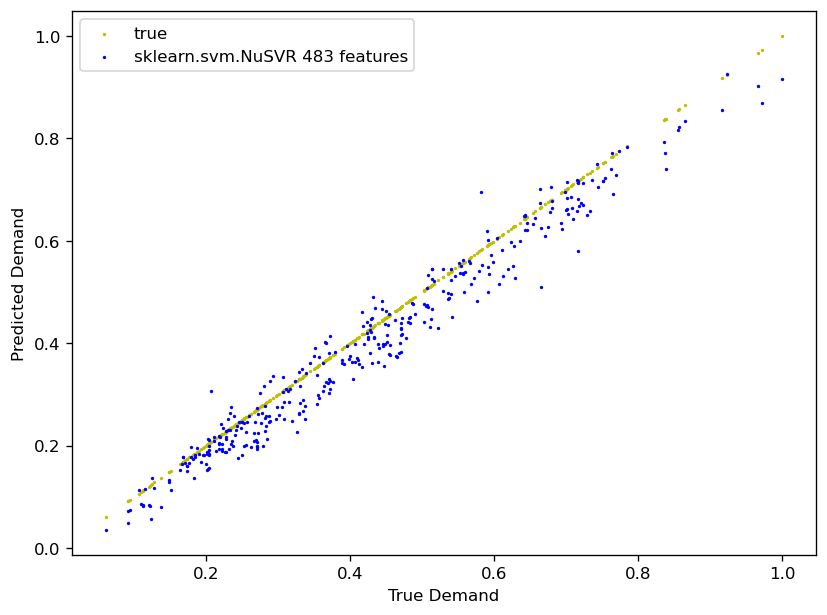

,Algorithm,Explained Variance,R2/COD,Max Error,Mean AE,Mean Squared Error,MAPE,Median AE
0,sklearn.svm.NuSVR 483 features,0.969354,0.951267,0.155811,0.034574,0.00189,0.095857,0.029967


In [15]:
model_desc = 'sklearn.svm.NuSVR ' + str(len(predictors_df.columns)) + ' features'

from sklearn.svm import NuSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#regr = make_pipeline(StandardScaler(), NuSVR(C=3.0, nu=0.1)) #originally C=1.0, nu=1.0
regr = NuSVR(C=3.0, nu=0.1, verbose=False ) #originally C=1.0, nu=1.0

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

# show results
myplot(model_desc, y_test, y_pred)

# save results for report
report = add_to_report(report, model_desc, y_test, y_pred)
report.tail(3)

In [16]:
#Example from https://pypi.org/project/sklearn-genetic/

from __future__ import print_function
import numpy as np
from sklearn import datasets, linear_model

from genetic_selection import GeneticSelectionCV

X = X_train
y = y_train



## Set the max number of features to search for here: 

In [17]:

# *maximum* number of features; the library will try a random number between 1 and max_features for each individual
max_features = 15

# number of individuals to create randomly 
n_population = 300

# number of generations to simulate
n_generations = 50  


In [18]:
# from https://pypi.org/project/sklearn-genetic/
# source code at https://github.com/manuel-calzolari/sklearn-genetic/blob/master/genetic_selection/gscv.py


# use a good performing (and fast!) algorithm as the estimator
estimator = NuSVR(C=3.0, nu=0.1, verbose=False)

selector = GeneticSelectionCV(estimator,
                              cv=5,
                              verbose=1,
                              #scoring="accuracy",
                              max_features=max_features, # was 5
                              n_population=n_population, # was 50
                              crossover_proba=0.5,
                              mutation_proba=0.2, # was 0.2 
                              n_generations=n_generations,
                              crossover_independent_proba=0.5,
                              mutation_independent_proba=0.05, # was 0.05
                              tournament_size=3,
                              n_gen_no_change=15,
                              caching=True,
                              n_jobs=4,           # local cpu has 4 cores, 8 threads
                              
                             )  

selector = selector.fit(X, y)


Selecting features with genetic algorithm.
gen	nevals	avg                    	std                    	min                      	max                      
0  	300   	[0.67160384 7.75      ]	[0.22569616 4.27560912]	[-1.03492479  1.        ]	[ 0.86631091 15.        ]
1  	190   	[-2399.40159553    15.21666667]	[4271.16757556    9.86862312]	[-1.e+04  1.e+00]        	[ 0.87306181 53.        ]
2  	168   	[-2232.69969108    15.59666667]	[4165.13936626    9.13312591]	[-1.e+04  3.e+00]        	[ 0.87922619 48.        ]
3  	163   	[-2232.68843577    16.44666667]	[4165.14540179    9.54326057]	[-1.e+04  5.e+00]        	[ 0.87922619 50.        ]
4  	168   	[-2166.00846872    16.05333333]	[4120.08186005    8.80248955]	[-1.e+04  7.e+00]        	[ 0.88893989 55.        ]
5  	166   	[-2566.03457399    17.76333333]	[4368.31017324   10.24470541]	[-1.e+04  7.e+00]        	[ 0.89551442 49.        ]
6  	181   	[-2799.38274032    18.05      ]	[4490.37379321   10.73782256]	[-1.e+04  4.e+00]        	[ 0.8955144

In [19]:
# Show my most fit individual algorithm's predictor columns:

predictors_df.columns[selector.support_]

Index(['is_Saturday', 'is_Sunday', 'TMIN_AR_MOUNTAIN_HOME_BAXTER_AP',
       'TMIN_LA_SHREVEPORT', 'TMIN_TX_LUBBOCK',
       'TMAX_MT_MILES_CITY_F_WILEY_FLD', 'TAVG_CO_ALAMOSA_SAN_LUIS_AP',
       'TAVG_IA_SIOUX_CITY_GATEWAY_AP', 'TAVG_KS_ANTHONY',
       'TAVG_MO_KANSAS_CITY_INTL_AP', 'TAVG_OK_TULSA_INTL_AP',
       'TAVG_TX_DALLAS_FT_WORTH_AP', 'CDD_NE_SCOTTSBLUFF_HEILIG_AP',
       'HDD_LA_SHREVEPORT', 'HDD_NE_VALENTINE_MILLER_FLD'],
      dtype='object')

## Now that I've found the N best predictors, re-do the SVM model with only those:


Input split into 1171 training observations and 364 testing observations.


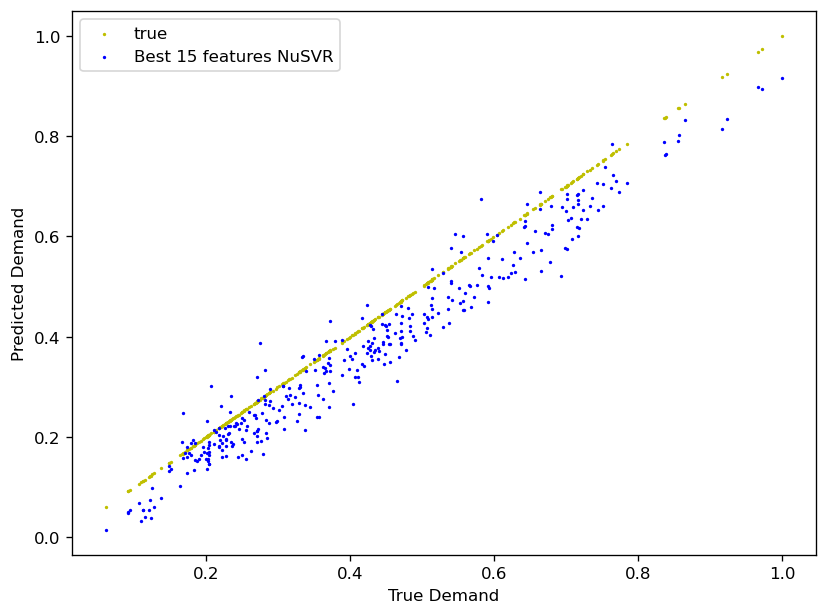

,Algorithm,Explained Variance,R2/COD,Max Error,Mean AE,Mean Squared Error,MAPE,Median AE
0,sklearn.svm.NuSVR 483 features,0.969354,0.951267,0.155811,0.034574,0.001890,0.095857,0.029967
1,Best 15 features NuSVR,0.956627,0.901369,0.171656,0.052719,0.003825,0.146798,0.048987


In [20]:
model_desc = 'Best '+ str(max_features) + ' features NuSVR'

new_predictors_df = predictors_df[predictors_df.columns[selector.support_]].copy()

new_predictor_names = new_predictors_df.columns.to_numpy()
new_predictors = new_predictors_df.to_numpy()

scaler = MinMaxScaler((0, 1))
X = scaler.fit_transform(new_predictors)
y = scaler.fit_transform(target.reshape(-1, 1)).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .237, shuffle=False)
print (f"Input split into {len(y_train)} training observations and {len(y_test)} testing observations.")

regr = NuSVR(C=3.0, nu=0.1, verbose=False ) #originally C=1.0, nu=1.0

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

# show results
myplot(model_desc, y_test, y_pred)

# save results for report
report = add_to_report(report, model_desc, y_test, y_pred)
report.sort_values(by='R2/COD', ascending=False)

## Compare to best scoring feature set from previous runs

Input split into 1171 training observations and 364 testing observations.


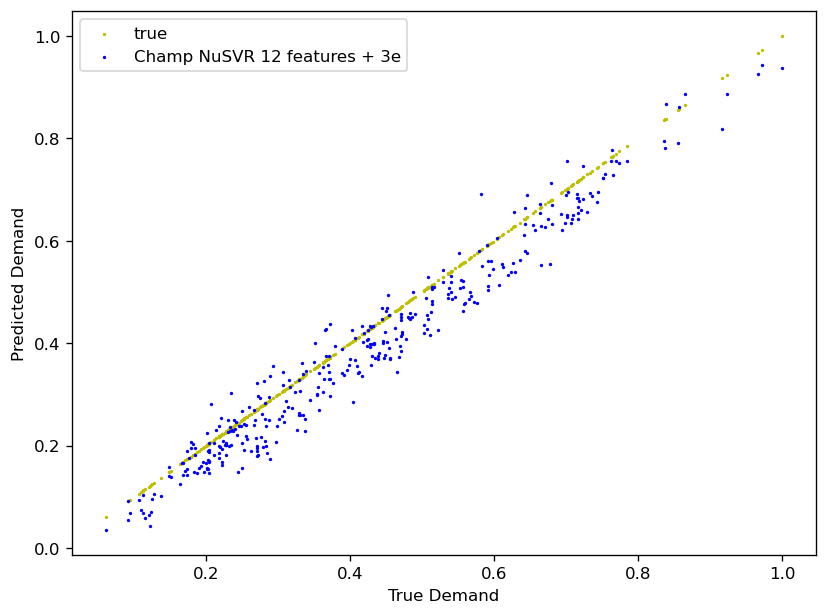

,Algorithm,Explained Variance,R2/COD,Max Error,Mean AE,Mean Squared Error,MAPE,Median AE
0,sklearn.svm.NuSVR 483 features,0.969354,0.951267,0.155811,0.034574,0.001890,0.095857,0.029967
2,Champ NuSVR 12 features + 3e,0.962970,0.936796,0.122731,0.041078,0.002451,0.116044,0.036761
1,Best 15 features NuSVR,0.956627,0.901369,0.171656,0.052719,0.003825,0.146798,0.048987


In [21]:
model_desc = 'Champ NuSVR 12 features + 3e'

new_predictors_df = target_df[[
    'is_Saturday', 
    'is_Sunday',
    'is_holiday', 
    "holiday_New Year's Day",
    'TAVG_AR_FT_SMITH_RGNL_AP', 
    'TAVG_IA_SIOUX_CITY_GATEWAY_AP',
    'TAVG_KS_DODGE_CITY',
    'TAVG_LA_SHREVEPORT', 
    'TAVG_MO_SPRINGFIELD',
    'TAVG_NE_LINCOLN_MUNI_AP', 
    'TAVG_OK_LAWTON_MUNI_AP',       # replacing Lawton with OKC improves explained variance score
    'TAVG_WY_TORRINGTON_MUNI_AP',

     # these two help model extremes
    'TMAX_MT_MILES_CITY_F_WILEY_FLD', 
    'TMIN_NM_ROSWELL_IND_AIR_PK',

 # these 4 can meaningfully improve the scores: 
    'TAVG_OK_OKLAHOMA_CITY_WILL_ROGERS_AP',  
#    'TAVG_KS_ANTHONY', 
#    'TAVG_NE_SCOTTSBLUFF_HEILIG_AP', 
#    'TAVG_KS_TOPEKA_MUNI_AP',
    
 
]].copy()

new_predictor_names = new_predictors_df.columns.to_numpy()
new_predictors = new_predictors_df.to_numpy()

scaler = MinMaxScaler((0, 1))
X = scaler.fit_transform(new_predictors)
y = scaler.fit_transform(target.reshape(-1, 1)).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .237, shuffle=False)
print (f"Input split into {len(y_train)} training observations and {len(y_test)} testing observations.")


regr = NuSVR(C=3.0, nu=0.1, verbose=False ) #originally C=1.0, nu=1.0

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

# show results
myplot(model_desc, y_test, y_pred)

# save results for report
report = add_to_report(report, model_desc, y_test, y_pred)
report.sort_values(by='R2/COD', ascending=False)

## Ideas for improvement: 
* Pre-seed population with high-scoring heros from previous run 
* Let it run all night and see if it can get any better from random mutations

## Next I'll use the stations and holidays identified here as relevant in more scikit-learn algorithms.